## ------------------ PROGRAM BEGINS ------------------

In [1]:
#import modules
%matplotlib inline

import pandas as pd # to import csv and for data manipulation
import matplotlib.pyplot as plt # to plot graph
import numpy as np # for linear algebra
from scipy.optimize import curve_fit # for curve fitting
from scipy.optimize import least_squares # for robust regression functions
import seaborn as sns # to plot chart
from pandas.plotting import register_matplotlib_converters 
register_matplotlib_converters()

### Read the data files 

In [2]:
prod_df = pd.read_csv("ND_PRODUCTION_DATA.csv")
well_df = pd.read_csv("ND_WELL_DATA.csv")

# check out the features
print(prod_df.columns)
print(well_df.columns)

Index([u'state', u'api', u'date', u'index', u'volume_oil_formation_bbls',
       u'volume_gas_formation_mcf', u'volume_water_formation_bbls',
       u'producing_days'],
      dtype='object')
Index([u'api', u'basin_name', u'bazean_id', u'bore_profile',
       u'completion_date', u'county', u'county_id', u'cum_12_boe',
       u'cum_12_gas', u'cum_12_mcfe', u'cum_12_oil', u'cum_12_water',
       u'cum_6_boe', u'cum_6_gas', u'cum_6_mcfe', u'cum_6_oil', u'cum_6_water',
       u'cum_gas', u'cum_oil', u'cum_water', u'cum_mcfe', u'cum_boe',
       u'density', u'drill_elevation', u'external_id', u'field_name',
       u'first_year_decline', u'frac_concentration', u'frac_date',
       u'frac_proppant', u'frac_proppant_type', u'frac_slickwater',
       u'frac_stages', u'frac_supplier', u'frac_volume', u'gas_comp',
       u'ground_elevation', u'ip24_oil', u'ip24_gas', u'ip24_water',
       u'ip24_mcfe', u'ip24_boe', u'ip30_oil', u'ip30_gas', u'ip30_water',
       u'ip30_mcfe', u'ip30_boe', u'ip_dat

Since each well is going to be individually fitted with a model, it is important to consider whether all of them are eligible to calibrate a model. Having just a few data points can easily overfit a model (with 2 or 3 parameters) and be misleading. For the sake of this analysis, I would only use wells with 6 or more months of production history in model calibration (even 6 data points still looks small, but we need to compromise between losing information and accuracy).

In [3]:
min_prod_months = 6
to_fit_API = well_df[well_df['prod_months'] >= min_prod_months]['api'] # This contains the APIs for wells with sufficient number of data points for model calibration
other_API = well_df[well_df['prod_months'] < min_prod_months]['api'] # Other APIs are stored here and will be used to identify bad wells

### Detecting wells that were considerd bad by their drilling company:  
I would call a well bad if it only had a few months of production and it's been several months since producing. We have data up until 2018-08-01. It should be safe to look at 6 months back.

In [4]:
max_date = prod_df[prod_df['api'].isin(other_API)].groupby(['api'], as_index=False)['date'].max()

In [5]:
# find the last date of production 
max_date = prod_df[prod_df['api'].isin(other_API)].groupby(['api'], as_index=False)['date'].max()
bad_API = max_date.iloc[(max_date['date'] < '2018-02-01').values]['api'] 

Wells with enough data points and bad wells will be included in this analysis. In other words, wells that were recently drilled and have very few data points are excluded from this study.

In [6]:
to_analyze_API = pd.concat([to_fit_API, bad_API], ignore_index=True)

# create a dataframe containing the useful data (features) for each well
# EUR and other relevant info will be added to this later
api_df = well_df[well_df['api'].isin(to_analyze_API)][['api','completion_date','operator_name','well_name']]

api_df['completion_date'] = pd.to_datetime(api_df['completion_date'])

In [7]:
# some wells appear to miss completion dates.
# find the first date of production for those and store as their completion date.

for api in to_analyze_API:
    if(pd.isnull(api_df[api_df['api'] == api]['completion_date']).values[0]):
        min_date = prod_df[prod_df['api'] == api]['date'].min();
        api_df.loc[api_df['api'] == api, 'completion_date'] = min_date

api_df['completion_date'] = pd.to_datetime(api_df['completion_date'])

In [8]:
# merge the useful parts of well and production data for our purpose in this problem
well_useful_info = ['api','operator_name']
prod_useful_info = ['api','date','volume_oil_formation_bbls']
df = pd.merge(well_df[well_df['api'].isin(to_analyze_API)][well_useful_info], prod_df[prod_df['api'].isin(to_analyze_API)][prod_useful_info], on='api')

# sort out by company, api, and date
df = df.sort_values(by=['operator_name','api','date']);

df['date'] = pd.to_datetime(df['date']);

We need to calculate EUR per well. First thing to consider is choosing an appropriate model for history matching of this data, which comes from the Bakken formation, an unconventional field. It has been shown that conventional models such as Arp's equations often lead to overestimation of EUR in unconventioanl resources (Paryani et al., 2011). It has been reported (Clark et al., 2011) that Logistic Growth Analysis (LGA) can capture production history of unconventional resources very well. Therefore, I would use LGA in this analysis.

### Logistic Growth Analysis (LGA)

LGA model is a hyperbolic equation with the following cumulative form:  
$Q(t) = \dfrac{K t^n}{a + t^n}$,  
where $Q(t)$ is the cumulative production at time $t$, and $K$ is the reservoir/well capacity. $a$ and $n$ are fitting parameters. As the capacity is typically unknown and we wish to estimate by history matching, $K$ is also used as a fitting constant. The rate form of the equation is as follows:  
$q(t) = \dfrac{a K n t^{n-1}}{(a + t^n)^2}$.

In [9]:
def LGA_cum(t, K, a, n):
    return K * t**n / (a + t**n)   

In [10]:
def LGA_rate(t, K, a, n):
    return a * K * n * t**(n-1) / ((a + t**n)**2)

In [11]:
# Calculate the cumulative oil production per well and add to a new column
df['cum_volume_oil_formation_bbls'] = df.groupby(['api'])['volume_oil_formation_bbls'].cumsum()

In [12]:
# LGA model requires to have t=0 as the start date of production
# Convert date of each api to the number of months in production
df.loc[:,'production_start_date'] = df.groupby(['api'])["date"].transform('min')
df.loc[:,'months_in_production'] = (df['date'] - df['production_start_date']).dt.days/30.5 + 1 # convert to months - first row is the first month

In [13]:
# Allocate memory for the fitting parameters per well
api_df.loc[:,'EUR'] = np.nan
api_df.loc[:,'LGA_a'] = np.nan
api_df.loc[:,'LGA_n'] = np.nan

## Outlier detection

As we are dealing with a public, raw dataset, outliers can very well exist in the production history of each well. Ignoring this fact can be very misleading in our analysis. A common way to detect outliers is to combine statistical tests with regression based methods (Chaudhary and Lee, 2016). The entire rate dataset initially calibrates the chosen model, then the noise in the dataset is fitted to a Gaussian distribution. Outliers are points which deviate more than x (usually x = 1.5) standard deviations from the model fit over the entire dataset. 

In [14]:
# %%timeit -n1 -r1  # to calculate run time for this block

# create an array for storing R^2 values of each model to assess model accuracy
r2 = np.zeros(to_fit_API.shape)

# fitting parameter for each well separately
for idx, api in enumerate(to_fit_API):
    
    thisWell = df[df['api'] == api][['months_in_production','volume_oil_formation_bbls','cum_volume_oil_formation_bbls']]

    # I will initially fit a model to data to detect outliers. Then, I'll recalibrate the model using the filtered data.
    t0 = thisWell['months_in_production'].values
    q0 = thisWell['volume_oil_formation_bbls'].values
    Q0 = thisWell['cum_volume_oil_formation_bbls'].values

    # some initial parameter values - must be within bounds
    # (K, a, n)
    initialParameters = np.array([np.max(Q0), 50.0, 2.0])

    # bounds on parameters - initial parameters must be within these
    lowerBounds = (np.max(Q0), 0.01, 1.75)
    upperBounds = (np.inf, 1000.0, 10.0)
    parameterBounds = [lowerBounds, upperBounds]

    # perform the curve fitting and find the optimum model parameters
    fittedParameters, pcov = curve_fit(LGA_rate, t0, q0, initialParameters, bounds = parameterBounds, max_nfev=100000)

    # values for display of fitted function
    K0, a0, n0 = fittedParameters

    # estimate error 
    q_pred = LGA_rate(t0, K0, a0, n0);
    err = q_pred - q0
    err_std = np.std(err)

    # a data point is called outlier if it's very different with the model prediction
    outliers = np.abs(q0 - q_pred) >= 1.5*err_std

    # Let's record if a data point is outlier or not. Outlier data will be excluded from the analaysis.
    df.loc[df['api'] == api,'outlier'] = outliers

    t = t0[~outliers]
    q = q0[~outliers]
    Q = Q0[~outliers]

    # some initial parameter values - must be within bounds
    # (K, a, n)
    initialParameters = np.array([np.max(Q), 50.0, 2.0])

    # bounds on parameters - initial parameters must be within these
    lowerBounds = (np.max(Q), 0.01, 1.75)
    upperBounds = (np.inf, 1000.0, 10.0)
    parameterBounds = [lowerBounds, upperBounds]

    # perform the curve fitting and find the optimum model parameters
    # it's easier to optimize the cumulative form equation (Clark, 2011)
    fittedParameters, pcov = curve_fit(LGA_cum, t, Q, initialParameters, bounds = parameterBounds, max_nfev=100000)

    # values for display of fitted function
    K, a, n = fittedParameters

    # estimate error 
    Q_pred = LGA_cum(t, K, a, n);
    residual = Q - Q_pred
    ss_res = np.sum(residual**2)
    ss_tot = np.sum((Q-np.mean(Q))**2)
    r2[idx] = 1 - (ss_res / ss_tot)

    api_df.loc[api_df['api'] == api,'EUR'] = K # K is the lifetime EUR
    api_df.loc[api_df['api'] == api,'LGA_a'] = a
    api_df.loc[api_df['api'] == api,'LGA_n'] = n
    
print 'Average $R^2$ for the fitted models: ' + str(r2.mean())

Average $R^2$ for the fitted models: 0.9595803015470884


In [15]:
print 'Average $R^2$ for the fitted models: ' + str(round(r2.mean(),3))

Average $R^2$ for the fitted models: 0.96


Average $R^2$ for the fitted models is %96, meaning that Logistic Growth Analysis has captured the data well. 

The above block took about a minute to complete, so I wouldn't bother to speed up. I could alternatively use scikit-learn tools like LabelEncoder, OneHotEncoder, or LabelBinarizer to do categorial-based training.

In [16]:
# for bad wells cumulative oil production is adopted as EUR.
for api in bad_API:
    Q = prod_df[prod_df['api'] == api].volume_oil_formation_bbls.sum()
    api_df.loc[api_df['api'] == api,'EUR'] = Q

# Question 1  
### Determine and summarize historical aggregate oil production by company over time

I would group the production data based on the operators first, then aggregate per api per date, eventually calculate the cumulative oil over time.

In [17]:
# add api wise production rates for each company over time.
# exclude the detected outliers.
group_data = df[df['outlier'] == False].groupby(['operator_name','date'])['volume_oil_formation_bbls'].sum()
group_data = group_data.reset_index()

# Setting date as index for plotting purposes
#group_data.set_index('date', inplace=True)

In [18]:
operators = df['operator_name'].unique()
print('List of operating companies: ')
print(operators)

List of operating companies: 
['ABRAXAS PETROLEUM CORP' 'CRESCENT POINT ENERGY US CORP'
 'ENERPLUS RESOURCES USA CORPORATION' 'KRAKEN OPERATING LLC'
 'LIBERTY RESOURCES MANAGEMENT COMPANY LLC' 'MARATHON OIL COMPANY'
 'MUREX PETROLEUM CORPORATION' 'PETRO-HUNT DAKOTA LLC'
 'SLAWSON EXPLORATION COMPANY INC' 'WPX ENERGY WILLISTON LLC']


## Analyzing the historical aggregate oil production by company

In [19]:
# A function to plot an individual well production over time
def plot_aggregate_production(operator, group_data, ax):
    dates = group_data[group_data['operator_name'] == operator]['date']
    productions = group_data[group_data['operator_name'] == operator]['volume_oil_formation_bbls'].cumsum().apply(lambda x: x*1e-3) # in thousand barrels
    
    ax.plot(dates.values, productions.values/1000.0)

    ax.autoscale(enable=True, tight=True);
    ax.set_xlabel('Date', fontsize=16);
    ax.set_ylabel('Cumulative oil production (million barrels)', fontsize=16);
    ax.set_title(operator,fontsize=16);
    ax.tick_params(labelsize=16);
    ax.minorticks_off();

    for tick in ax.get_xticklabels():
        tick.set_rotation(45); 

In [20]:
# A function to print an individual well production info
def print_aggregate_production(operator, group_data):
    dates = group_data[group_data['operator_name'] == operator]['date']
    productions = group_data[group_data['operator_name'] == operator]['volume_oil_formation_bbls'].cumsum().apply(lambda x: x*1e-3) # in thousand barrels
    completion_dates = api_df[api_df['operator_name'] == operator]['completion_date']
    
    print('Annual oil production (in thousand barrels) + annual number of well completions:')
    print('Before 2011: ') + str( int(productions[(dates>'2010-12-31').idxmax()]) ) + ' (' + str(completion_dates[(completion_dates < '2010-12-31')].count()) + ' well completions)'
    print('2011 - 2012: ') + str( int(productions[(dates>'2011-12-31').idxmax()] - productions[(dates>'2010-12-31').idxmax()]) ) + ' (' + str(completion_dates[(completion_dates>'2010-12-31') & (completion_dates<='2011-12-31')].count()) + ' well completions)'
    print('2012 - 2013: ') + str( int(productions[(dates>'2012-12-31').idxmax()] - productions[(dates>'2011-12-31').idxmax()]) ) + ' (' + str(completion_dates[(completion_dates>'2011-12-31') & (completion_dates<='2012-12-31')].count()) + ' well completions)'
    print('2013 - 2014: ') + str( int(productions[(dates>'2013-12-31').idxmax()] - productions[(dates>'2012-12-31').idxmax()]) ) + ' (' + str(completion_dates[(completion_dates>'2012-12-31') & (completion_dates<='2013-12-31')].count()) + ' well completions)'
    print('2014 - 2015: ') + str( int(productions[(dates>'2014-12-31').idxmax()] - productions[(dates>'2013-12-31').idxmax()]) ) + ' (' + str(completion_dates[(completion_dates>'2013-12-31') & (completion_dates<='2014-12-31')].count()) + ' well completions)'
    print('2015 - 2016: ') + str( int(productions[(dates>'2015-12-31').idxmax()] - productions[(dates>'2014-12-31').idxmax()]) ) + ' (' + str(completion_dates[(completion_dates>'2014-12-31') & (completion_dates<='2015-12-31')].count()) + ' well completions)'
    print('2016 - 2017: ') + str( int(productions[(dates>'2016-12-31').idxmax()] - productions[(dates>'2015-12-31').idxmax()]) ) + ' (' + str(completion_dates[(completion_dates>'2015-12-31') & (completion_dates<='2016-12-31')].count()) + ' well completions)'
    print('2017 - 2018: ') + str( int(productions[(dates>'2017-12-31').idxmax()] - productions[(dates>'2016-12-31').idxmax()]) ) + ' (' + str(completion_dates[(completion_dates>'2016-12-31') & (completion_dates<='2017-12-31')].count()) + ' well completions)'
    print('After 2018: ') + str( int(productions.values[-1] - productions[(dates>'2017-12-31').idxmax()]) ) + ' (' + str(completion_dates[(completion_dates>'2017-12-31')].count()) + ' well completions)'
    print('Total: ') + str( int(productions.values[-1]) ) + ' (' + str(completion_dates.count()) + ' wells)'

### ABRAXAS PETROLEUM CORP

Annual oil production (in thousand barrels) + annual number of well completions:
Before 2011: 13 (2 well completions)
2011 - 2012: 96 (1 well completions)
2012 - 2013: 93 (1 well completions)
2013 - 2014: 387 (10 well completions)
2014 - 2015: 944 (10 well completions)
2015 - 2016: 1169 (7 well completions)
2016 - 2017: 1484 (6 well completions)
2017 - 2018: 1625 (7 well completions)
After 2018: 946 (0 well completions)
Total: 6761 (44 wells)


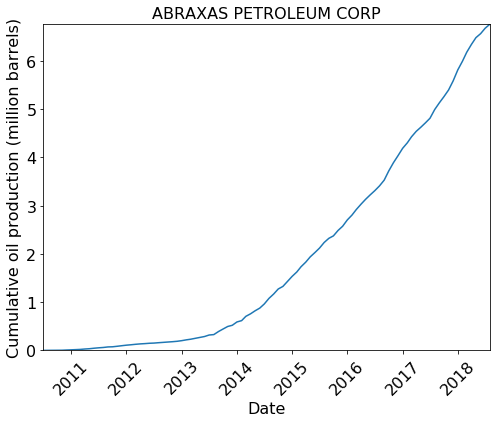

In [21]:
operator = 'ABRAXAS PETROLEUM CORP';
fig, ax = plt.subplots(figsize=(8,6));
plot_aggregate_production(operator, group_data, ax);
print_aggregate_production(operator, group_data);

### CRESCENT POINT ENERGY US CORP

Annual oil production (in thousand barrels) + annual number of well completions:
Before 2011: 3 (1 well completions)
2011 - 2012: 49 (2 well completions)
2012 - 2013: 420 (19 well completions)
2013 - 2014: 844 (5 well completions)
2014 - 2015: 710 (7 well completions)
2015 - 2016: 1045 (8 well completions)
2016 - 2017: 866 (8 well completions)
2017 - 2018: 1209 (7 well completions)
After 2018: 1334 (8 well completions)
Total: 6483 (65 wells)


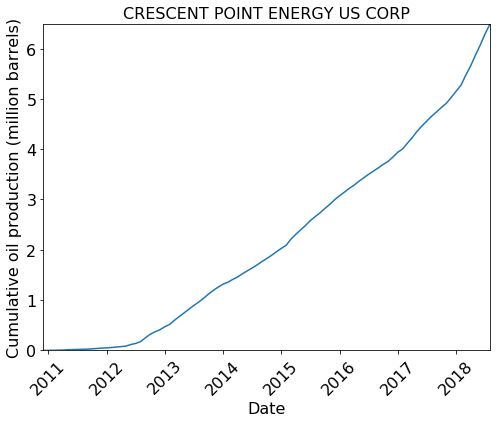

In [22]:
operator = 'CRESCENT POINT ENERGY US CORP';
fig, ax = plt.subplots(figsize=(8,6));
plot_aggregate_production(operator, group_data, ax);
print_aggregate_production(operator, group_data);

### ENERPLUS RESOURCES USA CORPORATION

Annual oil production (in thousand barrels) + annual number of well completions:
Before 2011: 1 (2 well completions)
2011 - 2012: 104 (4 well completions)
2012 - 2013: 232 (2 well completions)
2013 - 2014: 555 (6 well completions)
2014 - 2015: 1714 (12 well completions)
2015 - 2016: 2979 (8 well completions)
2016 - 2017: 2636 (7 well completions)
2017 - 2018: 4824 (22 well completions)
After 2018: 3086 (5 well completions)
Total: 16135 (68 wells)


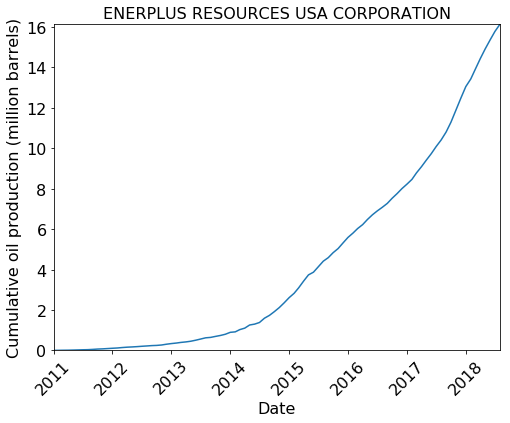

In [23]:
operator = 'ENERPLUS RESOURCES USA CORPORATION';
fig, ax = plt.subplots(figsize=(8,6));
plot_aggregate_production(operator, group_data, ax);
print_aggregate_production(operator, group_data);

### KRAKEN OPERATING LLC

Annual oil production (in thousand barrels) + annual number of well completions:
Before 2011: 184 (10 well completions)
2011 - 2012: 395 (10 well completions)
2012 - 2013: 1036 (23 well completions)
2013 - 2014: 1366 (15 well completions)
2014 - 2015: 1657 (10 well completions)
2015 - 2016: 1650 (3 well completions)
2016 - 2017: 1172 (0 well completions)
2017 - 2018: 2081 (22 well completions)
After 2018: 2676 (8 well completions)
Total: 12223 (101 wells)


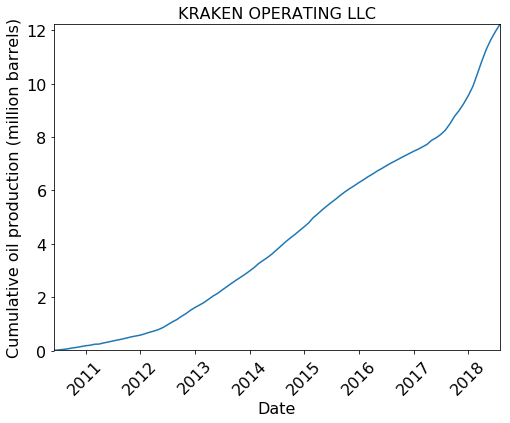

In [24]:
operator = 'KRAKEN OPERATING LLC';
fig, ax = plt.subplots(figsize=(8,6));
plot_aggregate_production(operator, group_data, ax);
print_aggregate_production(operator, group_data);

### LIBERTY RESOURCES MANAGEMENT COMPANY LLC

Annual oil production (in thousand barrels) + annual number of well completions:
Before 2011: 22 (0 well completions)
2011 - 2012: 0 (0 well completions)
2012 - 2013: 0 (0 well completions)
2013 - 2014: 448 (10 well completions)
2014 - 2015: 718 (9 well completions)
2015 - 2016: 1412 (14 well completions)
2016 - 2017: 1655 (7 well completions)
2017 - 2018: 1908 (17 well completions)
After 2018: 745 (0 well completions)
Total: 6911 (57 wells)


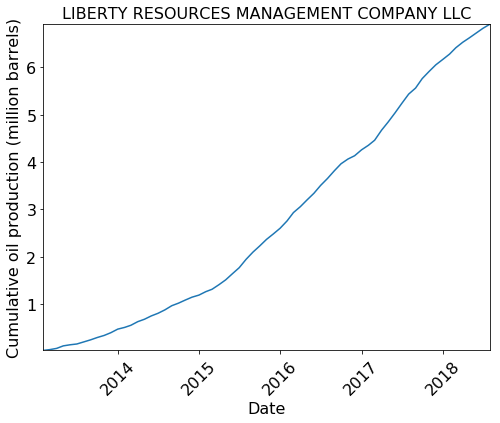

In [25]:
operator = 'LIBERTY RESOURCES MANAGEMENT COMPANY LLC';
fig, ax = plt.subplots(figsize=(8,6));
plot_aggregate_production(operator, group_data, ax);
print_aggregate_production(operator, group_data);

### MARATHON OIL COMPANY

Annual oil production (in thousand barrels) + annual number of well completions:
Before 2011: 2 (1 well completions)
2011 - 2012: 400 (9 well completions)
2012 - 2013: 536 (3 well completions)
2013 - 2014: 828 (3 well completions)
2014 - 2015: 977 (2 well completions)
2015 - 2016: 1190 (4 well completions)
2016 - 2017: 1509 (5 well completions)
2017 - 2018: 2785 (17 well completions)
After 2018: 4110 (9 well completions)
Total: 12341 (53 wells)


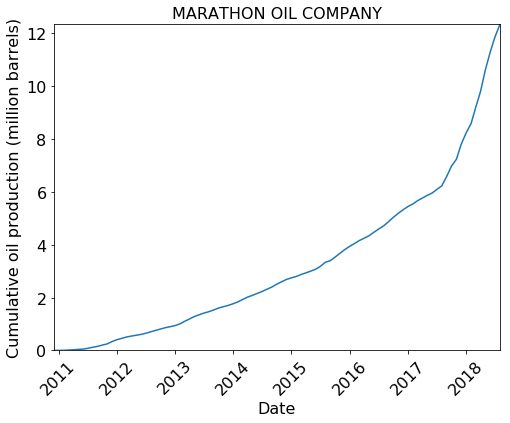

In [26]:
operator = 'MARATHON OIL COMPANY';
fig, ax = plt.subplots(figsize=(8,6));
plot_aggregate_production(operator, group_data, ax);
print_aggregate_production(operator, group_data);

### MUREX PETROLEUM CORPORATION

Annual oil production (in thousand barrels) + annual number of well completions:
Before 2011: 195 (11 well completions)
2011 - 2012: 582 (15 well completions)
2012 - 2013: 1043 (9 well completions)
2013 - 2014: 1040 (1 well completions)
2014 - 2015: 809 (0 well completions)
2015 - 2016: 681 (1 well completions)
2016 - 2017: 581 (0 well completions)
2017 - 2018: 525 (1 well completions)
After 2018: 280 (0 well completions)
Total: 5741 (38 wells)


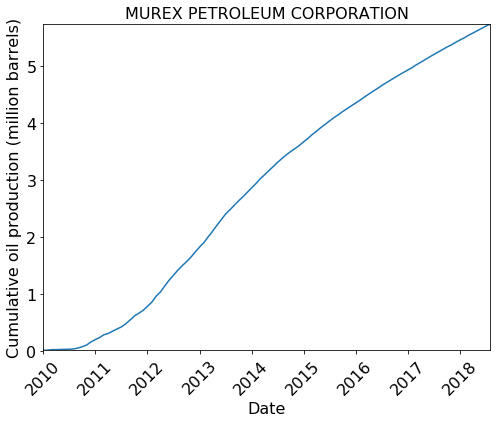

In [27]:
operator = 'MUREX PETROLEUM CORPORATION';
fig, ax = plt.subplots(figsize=(8,6));
plot_aggregate_production(operator, group_data, ax);
print_aggregate_production(operator, group_data);

### PETRO-HUNT DAKOTA LLC

Annual oil production (in thousand barrels) + annual number of well completions:
Before 2011: 8 (2 well completions)
2011 - 2012: 80 (1 well completions)
2012 - 2013: 84 (3 well completions)
2013 - 2014: 505 (19 well completions)
2014 - 2015: 1285 (25 well completions)
2015 - 2016: 1970 (14 well completions)
2016 - 2017: 1418 (0 well completions)
2017 - 2018: 1091 (0 well completions)
After 2018: 571 (0 well completions)
Total: 7016 (64 wells)


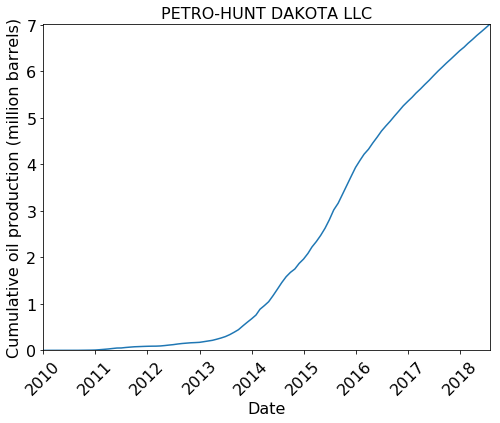

In [28]:
operator = 'PETRO-HUNT DAKOTA LLC';
fig, ax = plt.subplots(figsize=(8,6));
plot_aggregate_production(operator, group_data, ax);
print_aggregate_production(operator, group_data);

### SLAWSON EXPLORATION COMPANY INC

Annual oil production (in thousand barrels) + annual number of well completions:
Before 2011: 17 (3 well completions)
2011 - 2012: 88 (7 well completions)
2012 - 2013: 582 (13 well completions)
2013 - 2014: 956 (7 well completions)
2014 - 2015: 1210 (13 well completions)
2015 - 2016: 1321 (6 well completions)
2016 - 2017: 1085 (0 well completions)
2017 - 2018: 767 (0 well completions)
After 2018: 490 (1 well completions)
Total: 6520 (50 wells)


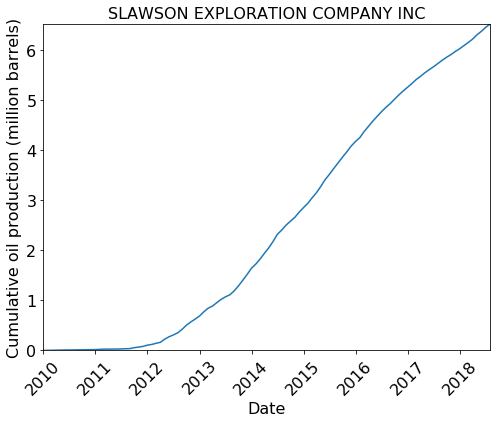

In [29]:
operator = 'SLAWSON EXPLORATION COMPANY INC';
fig, ax = plt.subplots(figsize=(8,6));
plot_aggregate_production(operator, group_data, ax);
print_aggregate_production(operator, group_data);

### WPX ENERGY WILLISTON LLC

Annual oil production (in thousand barrels) + annual number of well completions:
Before 2011: 83 (4 well completions)
2011 - 2012: 308 (5 well completions)
2012 - 2013: 849 (11 well completions)
2013 - 2014: 1019 (5 well completions)
2014 - 2015: 1327 (12 well completions)
2015 - 2016: 2095 (3 well completions)
2016 - 2017: 2534 (6 well completions)
2017 - 2018: 4377 (20 well completions)
After 2018: 2546 (0 well completions)
Total: 15141 (66 wells)


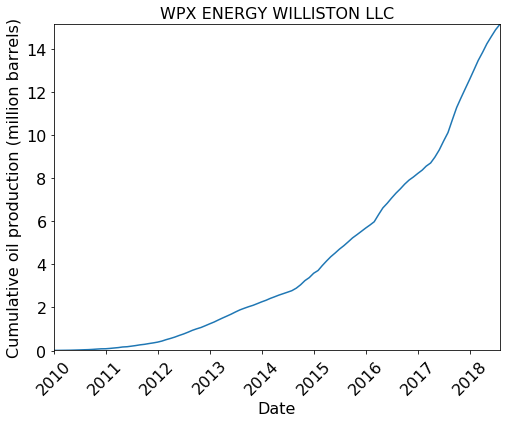

In [30]:
operator = 'WPX ENERGY WILLISTON LLC';
fig, ax = plt.subplots(figsize=(8,6));
plot_aggregate_production(operator, group_data, ax);
print_aggregate_production(operator, group_data);

## Plot all companies productions in one place

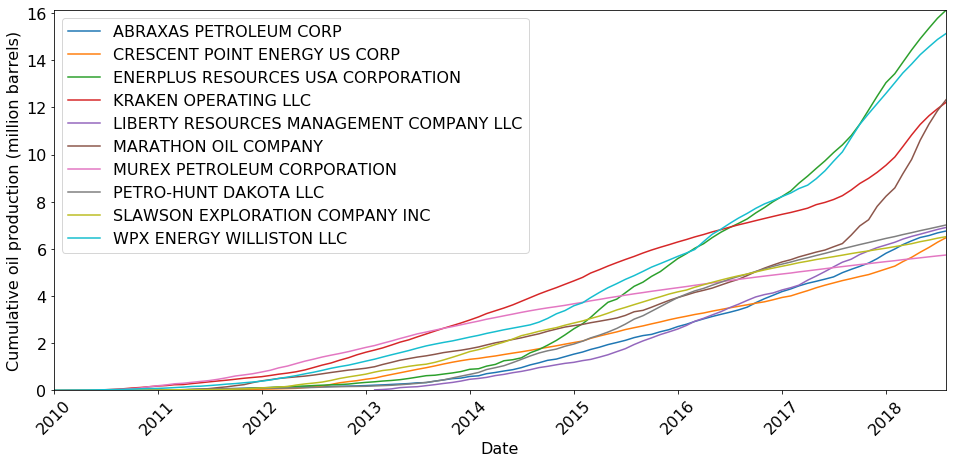

In [31]:
fig, ax = plt.subplots(figsize=(16,7));

for operator in operators:
    dates = group_data[group_data['operator_name'] == operator]['date']
    productions = group_data[group_data['operator_name'] == operator]['volume_oil_formation_bbls'].cumsum().apply(lambda x: x*1e-6) # in millions of barrels

    ax.plot(dates.values, productions.values, label=operator)

ax.autoscale(enable=True, tight=True);
ax.set_xlabel('Date', fontsize=16);
ax.set_ylabel('Cumulative oil production (million barrels)', fontsize=16);
ax.tick_params(labelsize=16);
ax.legend(fontsize=16);
ax.minorticks_off();

for tick in ax.get_xticklabels():
    tick.set_rotation(45); 

# Question 2  
### Determine and summarize oil EUR per well by company

As we have already calibrated the models, EURs can be calcualted using the fitted model. The parameter K in the Logistic Growth Model is the reservoir capacity or the lifetime EUR. As we are not specificly asked to calculate EUR at a given time, I will just use the lifetime EUR as my basis.

Since for each company we have several oil wells and thus EURs, I would like to fit a linear model to EUR profiles versus completion times. That will give us some insight on whether a company is improving its productions over time or not. 

In [32]:
EUR_slope = np.zeros(operators.shape)
EUR_intercept = np.zeros(operators.shape)

In [33]:
# define a linear function
def fun(c, t, y):
    return c[0]*t + c[1] - y

for idx, operator in enumerate(operators):
    
    thisOperator = api_df[api_df['operator_name'] == operator][['completion_date','EUR']]
    
    completion_date = thisOperator['completion_date'].values
    EUR = thisOperator['EUR'].values
    
    # fit a line to EUR vs. completion date (setting the first completion occurrence as reference)
    t = (completion_date - np.min(completion_date)).astype('timedelta64[D]') / np.timedelta64(1, 'D')
    y = EUR
    c0 = [0.0, y.mean()]
    res_lsq = least_squares(fun, c0, loss='huber', args=(t, y)).x # use a robust loss function to reduce outlier weights
    EUR_slope[idx] = res_lsq[0]
    EUR_intercept[idx] = res_lsq[1]

## Analyzing the EUR by company

In [34]:
# A function to plot an individual well EUR over time
def plot_EUR(thisOperator, EUR_slope, EUR_intercept, idx, ax):
    api = thisOperator['api'].values;
    completion_date = thisOperator['completion_date'].values;
    EUR = thisOperator['EUR'].values;
    x = (completion_date - np.min(completion_date)).astype('timedelta64[D]') / np.timedelta64(1, 'D'); # to plot the fitted line

    ax.plot(completion_date, EUR/1000.0, 'D'); 
    ax.plot(completion_date, (EUR_slope[idx]*x + EUR_intercept[idx])/1000.0);

    #ax.autoscale(enable=True, tight=True);
    ax.set_xlabel('Completion date', fontsize=16);
    ax.set_ylabel('Lifetime EUR (thousand barrels)', fontsize=16);
    ax.set_title(operator, fontsize=16);

    ax.tick_params(labelsize=16);
    ax.minorticks_off();

    for tick in ax.get_xticklabels():
        tick.set_rotation(45); 

In [35]:
# A function to print an individual well EUR info
def print_EUR(thisOperator):
    EUR = thisOperator['EUR'].values;
    
    print('Average EUR: ') + str( int(EUR.mean()/1000.0) ) + ' thousand barrels'
    print('Median EUR: ') + str( int(np.median(EUR)/1000.0) ) + ' thousand barrels'
    print('Standard deviation of EUR: ') + str( int(np.std(EUR)/1000.0) ) + ' thousand barrels'

### ABRAXAS PETROLEUM CORP

Average EUR: 213 thousand barrels
Median EUR: 207 thousand barrels
Standard deviation of EUR: 59 thousand barrels


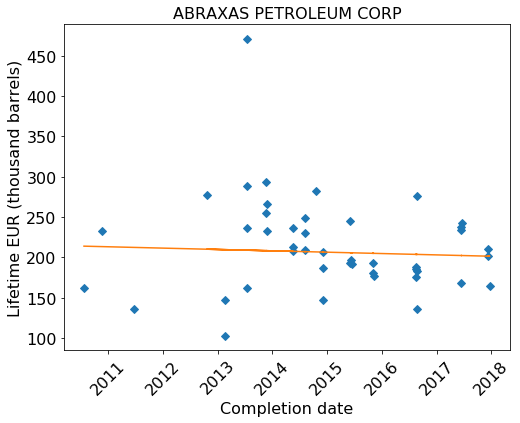

In [36]:
operator = 'ABRAXAS PETROLEUM CORP';
thisOperator = api_df[api_df['operator_name'] == operator][['api','completion_date','EUR']]
fig, ax = plt.subplots(figsize=(8,6));
idx = np.where(operators==operator)[0][0]; # to return its fitted EUR line
plot_EUR(thisOperator, EUR_slope, EUR_intercept, idx, ax);
print_EUR(thisOperator);

### CRESCENT POINT ENERGY US CORP

Average EUR: 144 thousand barrels
Median EUR: 145 thousand barrels
Standard deviation of EUR: 48 thousand barrels


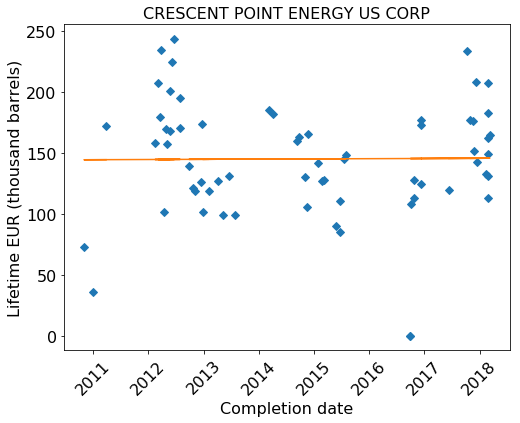

In [37]:
operator = 'CRESCENT POINT ENERGY US CORP';
thisOperator = api_df[api_df['operator_name'] == operator][['api','completion_date','EUR']]
fig, ax = plt.subplots(figsize=(8,6));
idx = np.where(operators==operator)[0][0]; # to return its fitted EUR line
plot_EUR(thisOperator, EUR_slope, EUR_intercept, idx, ax);
print_EUR(thisOperator);

### ENERPLUS RESOURCES USA CORPORATION

Average EUR: 337 thousand barrels
Median EUR: 298 thousand barrels
Standard deviation of EUR: 196 thousand barrels


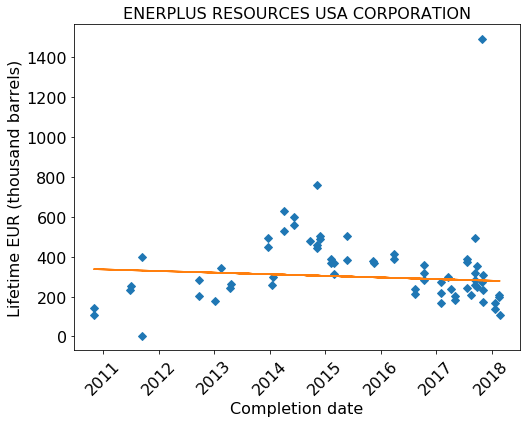

In [38]:
operator = 'ENERPLUS RESOURCES USA CORPORATION';
thisOperator = api_df[api_df['operator_name'] == operator][['api','completion_date','EUR']]
fig, ax = plt.subplots(figsize=(8,6));
idx = np.where(operators==operator)[0][0]; # to return its fitted EUR line
plot_EUR(thisOperator, EUR_slope, EUR_intercept, idx, ax);
print_EUR(thisOperator);

### KRAKEN OPERATING LLC

Average EUR: 168 thousand barrels
Median EUR: 162 thousand barrels
Standard deviation of EUR: 42 thousand barrels


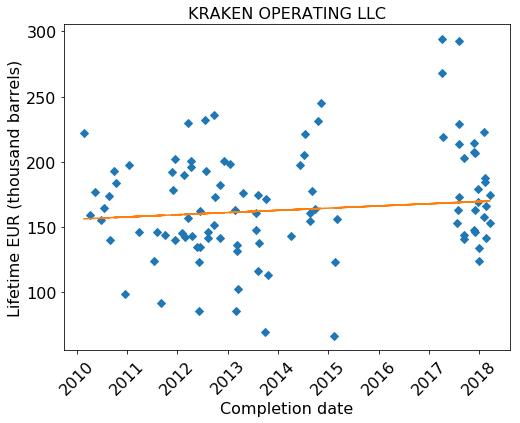

In [39]:
operator = 'KRAKEN OPERATING LLC';
thisOperator = api_df[api_df['operator_name'] == operator][['api','completion_date','EUR']]
fig, ax = plt.subplots(figsize=(8,6));
idx = np.where(operators==operator)[0][0]; # to return its fitted EUR line
plot_EUR(thisOperator, EUR_slope, EUR_intercept, idx, ax);
print_EUR(thisOperator);

### LIBERTY RESOURCES MANAGEMENT COMPANY LLC

Average EUR: 163 thousand barrels
Median EUR: 155 thousand barrels
Standard deviation of EUR: 84 thousand barrels


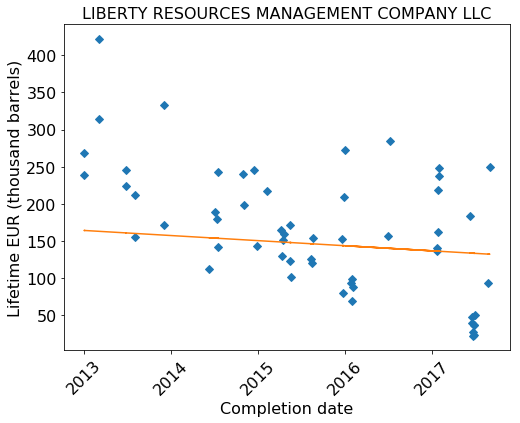

In [40]:
operator = 'LIBERTY RESOURCES MANAGEMENT COMPANY LLC';
thisOperator = api_df[api_df['operator_name'] == operator][['api','completion_date','EUR']]
fig, ax = plt.subplots(figsize=(8,6));
idx = np.where(operators==operator)[0][0]; # to return its fitted EUR line
plot_EUR(thisOperator, EUR_slope, EUR_intercept, idx, ax);
print_EUR(thisOperator);

### MARATHON OIL COMPANY

Average EUR: 319 thousand barrels
Median EUR: 304 thousand barrels
Standard deviation of EUR: 103 thousand barrels


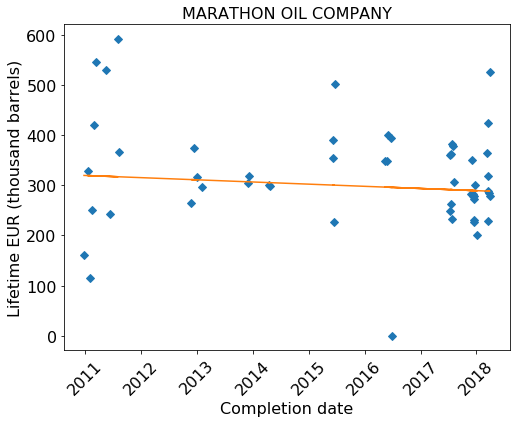

In [41]:
operator = 'MARATHON OIL COMPANY';
thisOperator = api_df[api_df['operator_name'] == operator][['api','completion_date','EUR']]
fig, ax = plt.subplots(figsize=(8,6));
idx = np.where(operators==operator)[0][0]; # to return its fitted EUR line
plot_EUR(thisOperator, EUR_slope, EUR_intercept, idx, ax);
print_EUR(thisOperator);

### MUREX PETROLEUM CORPORATION

Average EUR: 193 thousand barrels
Median EUR: 181 thousand barrels
Standard deviation of EUR: 78 thousand barrels


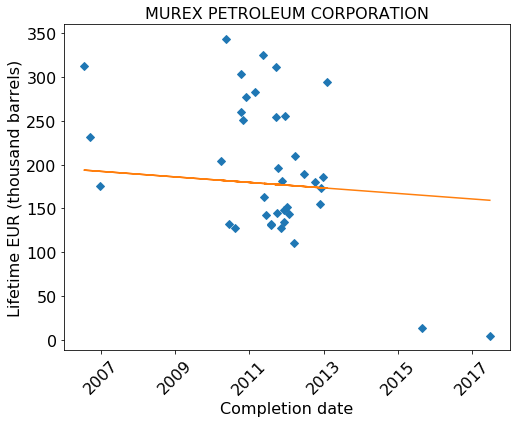

In [42]:
operator = 'MUREX PETROLEUM CORPORATION';
thisOperator = api_df[api_df['operator_name'] == operator][['api','completion_date','EUR']]
fig, ax = plt.subplots(figsize=(8,6));
idx = np.where(operators==operator)[0][0]; # to return its fitted EUR line
plot_EUR(thisOperator, EUR_slope, EUR_intercept, idx, ax);
print_EUR(thisOperator);

### PETRO-HUNT DAKOTA LLC

Average EUR: 137 thousand barrels
Median EUR: 135 thousand barrels
Standard deviation of EUR: 45 thousand barrels


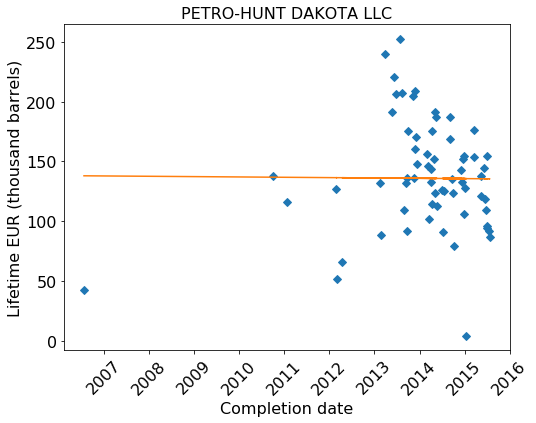

In [43]:
operator = 'PETRO-HUNT DAKOTA LLC';
thisOperator = api_df[api_df['operator_name'] == operator][['api','completion_date','EUR']]
fig, ax = plt.subplots(figsize=(8,6));
idx = np.where(operators==operator)[0][0]; # to return its fitted EUR line
plot_EUR(thisOperator, EUR_slope, EUR_intercept, idx, ax);
print_EUR(thisOperator);

### SLAWSON EXPLORATION COMPANY INC

Average EUR: 178 thousand barrels
Median EUR: 159 thousand barrels
Standard deviation of EUR: 101 thousand barrels


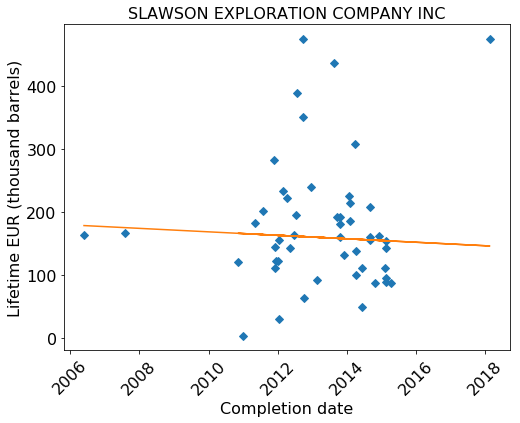

In [44]:
operator = 'SLAWSON EXPLORATION COMPANY INC';
thisOperator = api_df[api_df['operator_name'] == operator][['api','completion_date','EUR']]
fig, ax = plt.subplots(figsize=(8,6));
idx = np.where(operators==operator)[0][0]; # to return its fitted EUR line
plot_EUR(thisOperator, EUR_slope, EUR_intercept, idx, ax);
print_EUR(thisOperator);

### WPX ENERGY WILLISTON LLC

Average EUR: 306 thousand barrels
Median EUR: 305 thousand barrels
Standard deviation of EUR: 100 thousand barrels


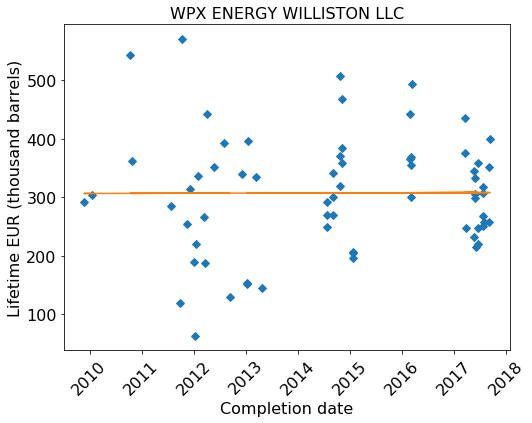

In [45]:
operator = 'WPX ENERGY WILLISTON LLC';
thisOperator = api_df[api_df['operator_name'] == operator][['api','completion_date','EUR']]
fig, ax = plt.subplots(figsize=(8,6));
idx = np.where(operators==operator)[0][0]; # to return its fitted EUR line
plot_EUR(thisOperator, EUR_slope, EUR_intercept, idx, ax);
print_EUR(thisOperator);

### Plotting all EUR trends in one place

A box chart can help to better visualize.

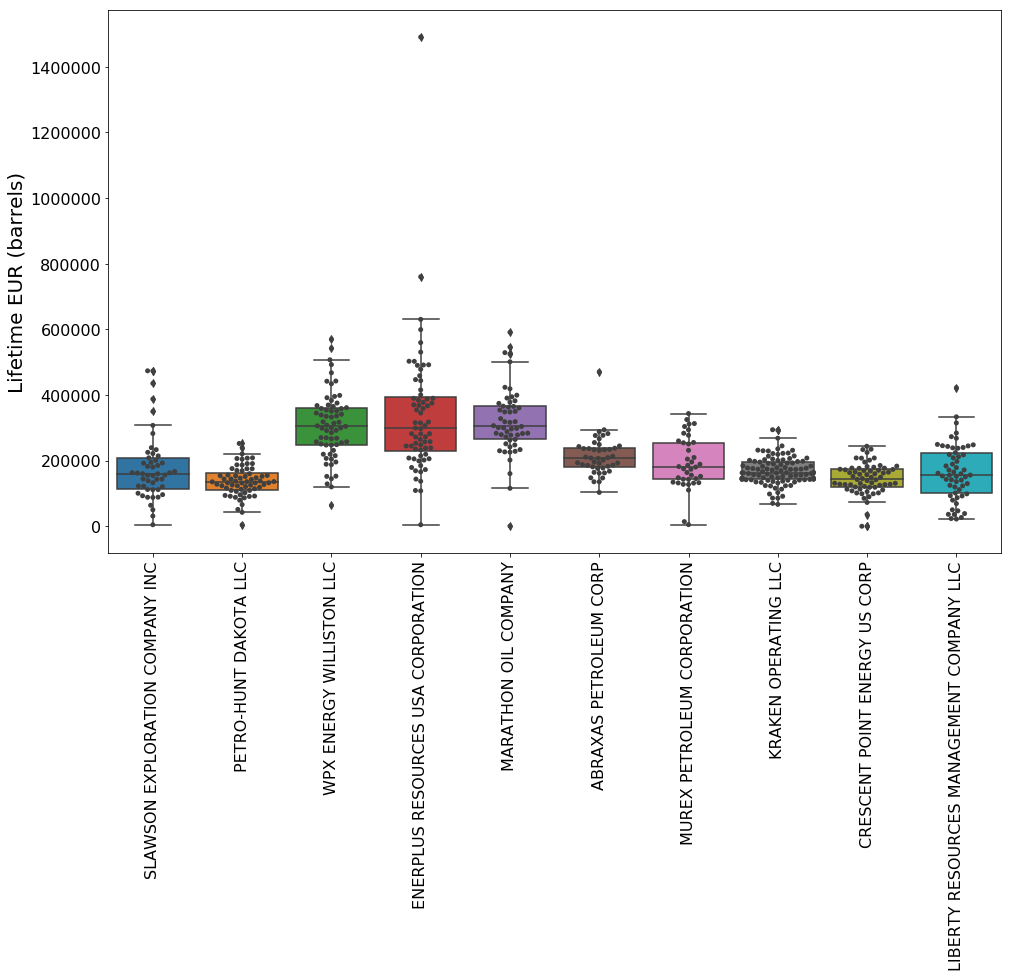

In [46]:
fig, ax = plt.subplots(figsize=(16,10));

sns.boxplot(x="operator_name", y="EUR", data=api_df, ax=ax);
sns.swarmplot(x="operator_name", y="EUR", data=api_df, color=".25")

ax.set_xlabel('');
ax.set_ylabel('Lifetime EUR (barrels)', fontsize=20);
ax.tick_params(labelsize=16);

for tick in ax.get_xticklabels():
    tick.set_rotation(90); 

# Question 3. 
### Based on ther history, which company or companiers are likely to drtill the most productive wells going forward?

I would plot the fitted EUR lines over time and compare by company.

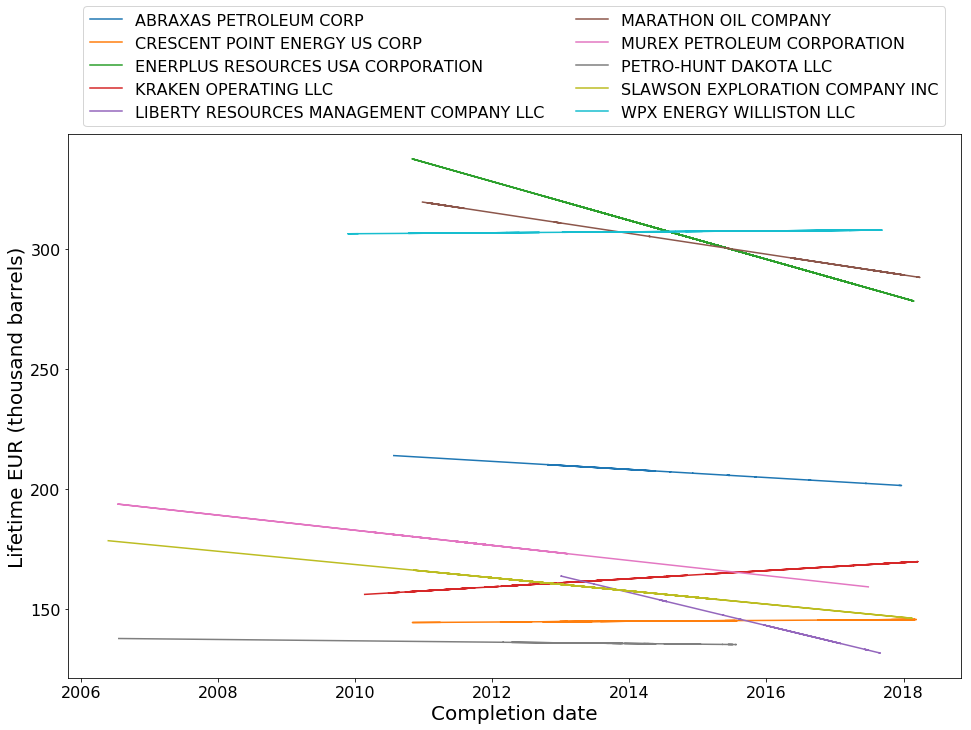

In [47]:
fig, ax = plt.subplots(figsize=(16,10));

for idx, operator in enumerate(operators):
    
    thisOperator = api_df[api_df['operator_name'] == operator][['api','completion_date']]

    completion_date = thisOperator['completion_date'].values
    
    x = (completion_date - np.min(completion_date)).astype('timedelta64[D]') / np.timedelta64(1, 'D') # for EUR linear fit
    ax.plot(completion_date, (EUR_slope[idx]*x + EUR_intercept[idx])/1000.0, label=operator); 

ax.set_xlabel('Completion date', fontsize=20);
ax.set_ylabel('Lifetime EUR (thousand barrels)', fontsize=20);
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fancybox=True, fontsize=16);

ax.tick_params(labelsize=16);


Based on this analysis, it looks like **WPX ENERGY WILLISTON LLC** has been consistently among the top producers per well since 2010. **MARATHON OIL COMPANY** is the runner-up here with a negative trend. While **ENERPLUS RESOURCES USA CORPORATION** was the top operator before 2014, it is currently placed in the third rank as its average well EUR seems to be decreasing.

Generally speaking, a negative slope does not mean a company is definitely going in the wrong direction. Based on the data, drastic changes in productions of some wells are evident. That might be due to refracking wells after a few years, leading to a sudden jump in production. That could increase the earlier EURs and decrease the slope of the curves.

While this analysis can be insightful, we should be mindful that the model may have not predicted wells with few data points (less than 1-2 years of history) accurately. LGA is more conservative compared to other models such as Arps and Duong models. I would have tested other models to see if I get consistent results, yet there is limited time given. A segmented model is also more suitable to use for wells with drastic changes in production.  
Also, the recent data (most of the completions in 2018) were ignored in this analysis, which could have been influential, i.e., a change in the EUR trend. Ideally, we would like to build a robust model (like a bayesian one) that can make a good prediction even with just a few data points.

A bayesian approach (like mcmc) might eventually give the best results. However, that requires a lot more time to build an appropriate model (the run time is largely higher too). If I were to do bayesian analysis, I would establish a model based on good data first (here, wells with long production history and few outliers). Then I would use that model as my prior information on the other data to detect outliers first and then make predictions. Especially for those wells with very few data points a bayesian model can work best.